In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import*

In [3]:
path = Path('/home/jupyter/.fastai/data/camvid-tiramisu')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/train.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/models'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/test.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/test'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/testannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/trainannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/valannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/train')]

In [5]:
# Data

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08093.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08059.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_07983.png')]

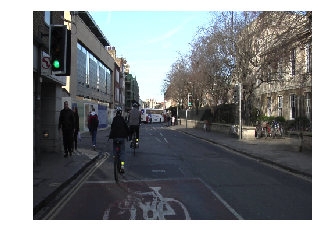

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [8]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

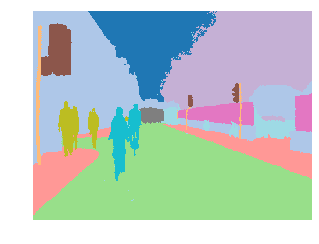

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [11]:
# Datasets

In [12]:
bs,size = 8,src_size//2

In [13]:
src = (SegmentationItemList.from_folder(path)
      .split_by_folder(valid='val')
      .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

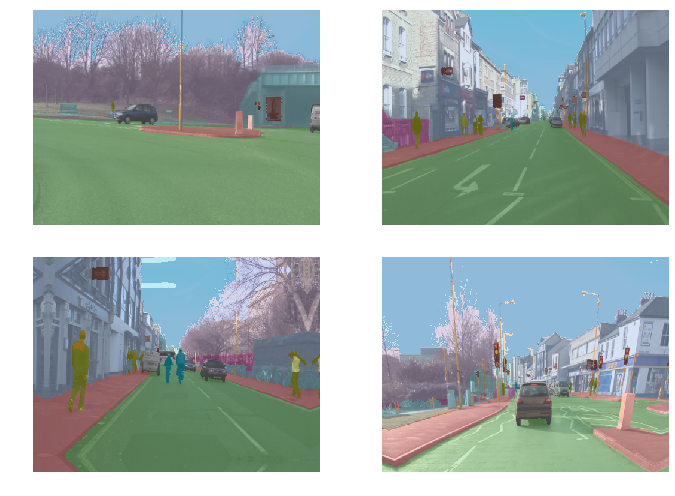

In [15]:
data.show_batch(2, figsize=(10,7))

In [16]:
# Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


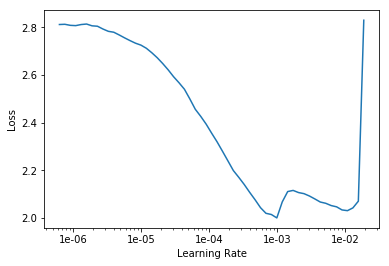

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=2e-3

In [22]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.048231,0.813524,0.778133,00:31
1,0.725493,0.563103,0.821375,00:28
2,0.622979,0.567329,0.846191,00:28
3,0.562855,0.451341,0.856627,00:28
4,0.494844,0.418012,0.879483,00:28
5,0.469821,0.493443,0.843626,00:28
6,0.445670,0.366945,0.884860,00:28
7,0.412585,0.440877,0.859392,00:28
8,0.383674,0.341382,0.884558,00:28
9,0.338490,0.283115,0.906190,00:28


In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [25]:
learn.unfreeze()

In [26]:
lrs = slice(lr/100, lr)

In [27]:
learn.fit_one_cycle_cycle_cycle_cycle_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.287569,0.245953,0.925214,00:29
1,0.276976,0.258419,0.921030,00:29
2,0.270529,0.268345,0.914343,00:29
3,0.274851,0.311347,0.899184,00:29
4,0.300587,0.330561,0.909535,00:29
5,0.306071,0.274548,0.915254,00:29
6,0.305625,0.348222,0.895743,00:29
7,0.307667,0.365281,0.899166,00:29
8,0.299324,0.256303,0.916989,00:29
9,0.293905,0.357030,0.904145,00:29


In [28]:
learn.save('stage-2')

In [29]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [30]:
# Go Big

In [31]:
learn = None
gc.collect()

280

In [32]:
size = src_size
bs = 8

In [33]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [34]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2').to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


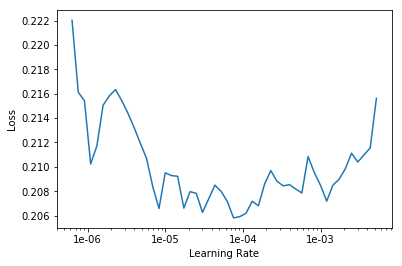

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr=1e-3

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.207891,0.240798,0.928647,00:28
1,0.205152,0.248073,0.926245,00:28
2,0.200663,0.251580,0.928860,00:28
3,0.198557,0.255891,0.925859,00:28
4,0.199897,0.255605,0.932452,00:28
5,0.197850,0.276088,0.925717,00:28
6,0.196878,0.268735,0.927558,00:28
7,0.196008,0.258637,0.933321,00:28
8,0.191006,0.233799,0.934240,00:28
9,0.174046,0.233878,0.937788,00:28


In [38]:
learn.save('stage-1-big')

In [39]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(lr/1000, lr/10)

In [42]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.159931,0.242774,0.935543,00:29
1,0.157913,0.239523,0.936479,00:29
2,0.158160,0.247660,0.936134,00:29
3,0.157360,0.229699,0.937729,00:29
4,0.156271,0.231699,0.938661,00:29
5,0.154489,0.226024,0.940454,00:29
6,0.152731,0.231752,0.939138,00:29
7,0.149920,0.231891,0.938749,00:29
8,0.148625,0.234723,0.938511,00:29
9,0.147017,0.235815,0.938387,00:29


In [43]:
learn.save('stage-2-big')

In [44]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid-tiramisu;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

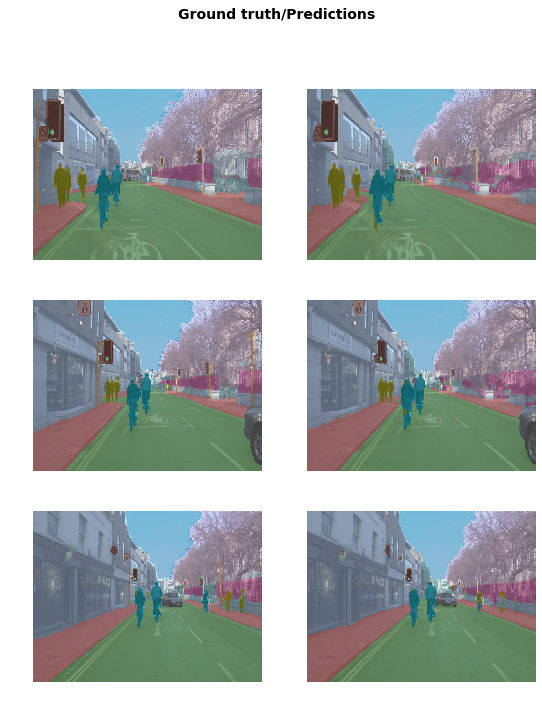

In [45]:
learn.show_results(rows=3, figsize=(9,11))

In [46]:
# Fin

In [47]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 180, 240]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [1, 64, 90, 120]     36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [1, 64, 90, 120]     0          False     
______________________________________________________________